# Thư viện cần thiết:

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import gc
import json
import zipfile

from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch import nn
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random

import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

In [2]:
# Configure PyTorch memory allocation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Using device: cuda
GPU Memory Available: 15.83 GB


## Fully Connected Layer:

In [3]:
# define hyperameters
input_size = 4
hidden_size = 1080
num_classes = 4
num_epochs = 100
batch_size = 64
learning_rate = 2e-5

In [4]:
class NeuralNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        # Định nghĩa mô hình sử dụng nn.Sequential
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.BatchNorm1d(hidden_size),  
            nn.Dropout(0.2),
            

            # Dùng hàm activation GELU: đưa các giá trị âm về 0, trong khi giữ nguyên các giá trị dương
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_size, num_classes)  # Lớp Linear đầu ra với số lớp đầu ra là num_classes  
        )
        self._initialize_weights()  # Khởi tạo trọng số ngay khi tạo mô hình

        

        # Xavier initialization
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def _initialize_weights(self):
        # Phương thức khởi tạo trọng số cho các lớp trong mô hình
        for layer in self.model:
            if isinstance(layer, nn.Linear):  # Kiểm tra nếu lớp là Linear
                # Sử dụng He initialization cho trọng số
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
                if layer.bias is not None:  # Kiểm tra nếu có bias
                    nn.init.zeros_(layer.bias)  # Khởi tạo bias bằng 0


    def forward(self, x):
        # Dùng hàm activation Softmax: chuyển các điểm số thành xác suất
        logits = self.model(x)  # Thực hiện forward pass qua mô hình
        probabilities = nn.functional.softmax(logits, dim=1)  # Tính toán xác suất đầu ra
        return probabilities  # Trả về xác suất

## Hàm xử lý:

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size)
        )
        self.gelu = nn.GELU()
        
    def forward(self, x):
        identity = x
        out = self.block(x)
        out += identity  # Residual connection
        return self.gelu(out)

In [6]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
class EarlyStopping:
    def __init__(self, patience: int = 20, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False


    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.should_stop

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [9]:
def train_and_evaluate(val_pred_probs, val_labels,
                      hidden_size=hidden_size, 
                      epochs=num_epochs, batch_size=batch_size, 
                      learning_rate=learning_rate,
                      temperature=2.0,
                      clip_value = 1.0,
                      fold=0):

    # Chuẩn bị data
    X = val_pred_probs
    y = val_labels

    

    # Chia validation set (80% train, 20% eval)
    dataset = TensorDataset(X, y)
    train_size = int(0.8 * len(dataset))  
    eval_size = len(dataset) - train_size  
    train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

    

    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,
                              num_workers=4)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size,
                             num_workers=4)

    

    # Tính class weights
    class_counts = np.bincount(y.cpu().numpy())
    total_samples = len(y)

    class_weights = torch.FloatTensor(
        [total_samples/(len(class_counts)*count) for count in class_counts]).to(device)

    

    # Khởi tạo model
    input_size = X.shape[1]  # số features (pred_prob_1 + pred_prob_2
    model = NeuralNet(input_size, hidden_size, num_classes).to(device)

    

    # Sử dụng AdamW với weight decay và gradient clipping

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01
    )

    

    # Label smoothing trong loss function
    criterion = nn.CrossEntropyLoss(
        weight=class_weights,
        label_smoothing=0.1
    )

    

    # Learning rate scheduler với warmup
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,  # 30% epochs for warmup
        anneal_strategy='linear'
    )

    

    # AMP cho mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Training
    best_f1 = 0
    best_model_state = None  # Khởi tạo biến cho mô hình tốt nhất
    patience = 10
    no_improve = 0

    

    for epoch in tqdm(range(epochs), desc='Training'):
        # Training phase
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        all_eval_probs = []  # Để lưu xác suất

        

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            

            with torch.cuda.amp.autocast():
                outputs = model(batch_X.to(device))  # Chuyển batch_X sang device
                #probs = nn.functional.softmax(outputs, dim=1)  # Tính xác suất
            
            # Apply temperature scaling
                scaled_logits = outputs / temperature  
                probs = nn.functional.softmax(scaled_logits, dim=1)
                all_eval_probs.append(probs.detach().cpu().numpy())  # Sử dụng detach()
            #loss = criterion(outputs, batch_y.to(device))  # Chuyển batch_y sang device
            #loss.backward()
                loss = criterion(scaled_logits, batch_y.to(device))
            
            # Backward pass with gradient clipping
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            scaler.step(optimizer)
            scaler.update()
            

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(batch_y.cpu().numpy())

        

        # Evaluation phase
        model.eval()
        all_eval_preds = []
        all_eval_labels = []

        

        with torch.no_grad():
            for batch_X, batch_y in eval_loader:
                outputs = model(batch_X.to(device))  # Chuyển batch_X sang device
                _, predicted = torch.max(outputs.data, 1)
                all_eval_preds.extend(predicted.cpu().numpy())
                all_eval_labels.extend(batch_y.cpu().numpy())

        

        # Kết hợp xác suất
        all_eval_probs = np.concatenate(all_eval_probs)

        
        # Tính F1 score
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        eval_f1 = f1_score(all_eval_labels, all_eval_preds, average='weighted')
        accuracy = accuracy_score(all_eval_labels, all_eval_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_eval_labels, all_eval_preds, average='weighted')

        

        val_metrics = {
            'accuracy': accuracy_score(all_eval_labels, all_eval_preds),
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'probabilities': all_eval_probs,
            'labels': all_eval_labels
        }

        cm = confusion_matrix(all_eval_labels, all_eval_preds)


        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}')
        print(f'Eval F1: {eval_f1:.4f}, Eval Precision: {precision:.4f}, Eval Recall: {recall:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print('Confusion Matrix:\n', cm)

        # Vẽ confusion matrix
        plot_confusion_matrix(cm, class_names=[str(i) for i in range(num_classes)])
        print('-' * 50)

       

        # Save best model based on F1 score
        if eval_f1 > best_f1:
            best_f1 = eval_f1
            best_model_state = model.state_dict()  # Lưu trạng thái của mô hình
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': val_metrics,
            }, f'best_model_epoch_{epoch}.pt')


            print(f'Best model saved at epoch {epoch} with F1 score: {best_f1:.4f}')
            no_improve = 0
        else:
            no_improve += 1

        
        # Early stopping
        if no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    
    return model

In [89]:
def predict_test(model, test_pred_prob_1, test_pred_prob_2):
    model.eval()
    with torch.no_grad():
        X_test = torch.cat([test_pred_prob_1, test_pred_prob_2], dim=1)
        probabilities = model(X_test).to(device)

        # Chuyển xác suất thành nhãn lớp dự đoán
        predicted_labels = torch.argmax(probabilities, dim=1)

    return probabilities, predicted_labels

## Chuẩn bị đầu vào:

In [11]:
model_1 = torch.load('/kaggle/input/final-prob/roberta_model_fold_1.pt')
pred_prob_1 = torch.tensor(model_1['probabilities'])
val_label = torch.tensor(model_1['val_labels'])
val_label_1 = val_label.long()


print("Shape của pred_prob_1:", pred_prob_1.shape)

print("Shape của val_label_1:", val_label_1.shape)
model_1['metrics']['f1_score']

Shape của pred_prob_1: torch.Size([3061, 2])
Shape của val_label_1: torch.Size([3061])


0.706917630618046

In [12]:
print(pred_prob_1)
print(val_label_1)

tensor([[0.7309, 0.2691],
        [0.4284, 0.5716],
        [0.7309, 0.2691],
        ...,
        [0.4129, 0.5871],
        [0.7307, 0.2693],
        [0.6291, 0.3709]])
tensor([0, 0, 0,  ..., 1, 0, 0])


In [85]:
model_2 = torch.load('/kaggle/input/old-clip/CLIP_model_fold_2_new.pt')
pred_prob_2 = torch.tensor(model_2['probabilities'])
val_label = torch.tensor(model_2['val_labels'])
val_label_2 = val_label.long()

print("Shape của pred_prob_2:", pred_prob_2.shape)
print("Shape của val_label_2:", val_label_2.shape)
model_2['metrics']['f1_score']

Shape của pred_prob_2: torch.Size([3061, 2])
Shape của val_label_2: torch.Size([3061])


0.7215639123219073

In [86]:
print(pred_prob_2)
print(val_label_2)

tensor([[0.3104, 0.6896],
        [0.3971, 0.6029],
        [0.7252, 0.2748],
        ...,
        [0.7298, 0.2702],
        [0.7241, 0.2759],
        [0.2791, 0.7209]])
tensor([1, 1, 0,  ..., 0, 0, 0])


## Chuẩn bị đầu ra:

## Public:

In [87]:
test_1 = torch.load('/kaggle/input/final-prob/roberta_pub_15.pt')
test_pub_1 = torch.tensor(test_1['probabilities']).to(device)
test_pred_1 = torch.tensor(test_1['predictions']).to(device)
test_pred_1 = test_pred_1.long()



print(test_pub_1)
print(test_pred_1)
print("Shape:", test_pred_1.shape)

test_2 = torch.load('/kaggle/input/old-clip/clip_pub_old.pt')
test_pub_2 = torch.tensor(test_2['probabilities']).to(device)
test_pred_2 = torch.tensor(test_2['predictions']).to(device)


print(test_pub_2)
print(test_pred_2)
print("Shape:", test_pred_2.shape)

tensor([[0.4135, 0.5865],
        [0.4284, 0.5716],
        [0.4713, 0.5287],
        ...,
        [0.4253, 0.5747],
        [0.4253, 0.5747],
        [0.4348, 0.5652]], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
Shape: torch.Size([1413])
tensor([[0.3935, 0.6065],
        [0.4198, 0.5802],
        [0.4587, 0.5413],
        ...,
        [0.3911, 0.6089],
        [0.4034, 0.5966],
        [0.3841, 0.6159]], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
Shape: torch.Size([1413])


In [88]:
# Load test data
file = '/kaggle/input/test-public/vimmsd-public-test.json'
with open(file) as data:
    dict_data = json.load(data)


test_pub = pd.DataFrame.from_dict(dict_data, orient='index')
test_pub.reset_index(level=0, inplace=True)
print(f"Test samples: {len(test_pub)}")

Test samples: 1413


## Private:

In [62]:
test_1 = torch.load('/kaggle/input/final-prob/roberta_priv_15.pt')
test_priv_1 = torch.tensor(test_1['probabilities']).to(device)
test_pred_1 = torch.tensor(test_1['predictions']).to(device)
test_pred_1 = test_pred_1.long()



print(test_priv_1)
print(test_pred_1)
print("Shape:", test_pred_1.shape)

tensor([[0.7308, 0.2692],
        [0.7308, 0.2692],
        [0.7308, 0.2692],
        ...,
        [0.3928, 0.6072],
        [0.3984, 0.6016],
        [0.4283, 0.5717]], device='cuda:0')
tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')
Shape: torch.Size([1504])


In [63]:
test_2 = torch.load('/kaggle/input/final-prob/clip_priv_18.pt')
test_priv_2 = torch.tensor(test_2['probabilities']).to(device)
test_pred_2 = torch.tensor(test_2['predictions']).to(device)


print(test_priv_2)
print(test_pred_2)
print("Shape:", test_pred_2.shape)

tensor([[0.7263, 0.2737],
        [0.7232, 0.2768],
        [0.7201, 0.2799],
        ...,
        [0.3629, 0.6371],
        [0.3572, 0.6428],
        [0.4569, 0.5431]], device='cuda:0')
tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')
Shape: torch.Size([1504])


In [96]:
# Load test data
file = '/kaggle/input/test-private/vimmsd-private-test.json'
with open(file) as data:
    dict_data = json.load(data)


test_priv = pd.DataFrame.from_dict(dict_data, orient='index')
test_priv.reset_index(level=0, inplace=True)
print(f"Test samples: {len(test_priv)}")

Test samples: 1504


# Phương pháp: Map lại label, cho nó học rồi dự đoán nhãn:

In [97]:
## Chỉnh sửa lại nhãn cho phù hợp
def map_predictions(pred_1, pred_2):
    # Tạo danh sách để lưu nhãn cuối cùng
    final_labels = []

    for p1, p2 in zip(pred_1, pred_2):
        if p1 == 0 and p2 == 1:
            final_labels.append('image-sarcasm')
        elif p1 == 0 and p2 == 0:
            final_labels.append('not-sarcasm')
        elif p1 == 1 and p2 == 1:
            final_labels.append('multi-sarcasm')
        elif p1 == 1 and p2 == 0:
            final_labels.append('text-sarcasm')

    return final_labels

In [98]:
val_labels = map_predictions(val_label_1, val_label_2)

In [99]:
# Chuyển đổi nhãn cuối cùng thành số nếu cần thiết

label_mapping = {
    'multi-sarcasm': 0,
    'not-sarcasm': 1,
    'text-sarcasm': 2,
    'image-sarcasm': 3
}

val_labels = [label_mapping[label] for label in val_labels]

In [100]:
val_labels = torch.tensor(val_labels)
labels_2 = val_labels.long()
labels_2

# Tìm các giá trị duy nhất
unique_values = torch.unique(labels_2)

# In ra các giá trị duy nhất
print("Các giá trị duy nhất trong tensor:", unique_values)
labels_2.size()

Các giá trị duy nhất trong tensor: tensor([0, 1, 2, 3])


torch.Size([3061])

In [101]:
torch.sum(labels_2 == 0)

tensor(540)

## Áp dụng Fully connected layer:

In [102]:
print(f"val_pred_prob_1 shape: {pred_prob_1.shape}")
print(f"val_pred_prob_2 shape: {pred_prob_2.shape}")
print(f"val_labels shape: {labels_2.shape}")

val_pred_prob_1 shape: torch.Size([3061, 2])
val_pred_prob_2 shape: torch.Size([3061, 2])
val_labels shape: torch.Size([3061])


In [103]:
min_size = min(pred_prob_1.shape[0], pred_prob_2.shape[0])
pred_prob_1 = pred_prob_1[:min_size]
pred_prob_2 = pred_prob_2[:min_size]
val_pred_probs = torch.cat([pred_prob_1, pred_prob_2], dim=1)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100]
Train Loss: 1.3779, Train F1: 0.3276
Eval F1: 0.3789, Eval Precision: 0.4300, Eval Recall: 0.4258
Accuracy: 0.4258
Confusion Matrix:
 [[ 63  27   8   1]
 [ 28 126  41   2]
 [ 38  44  64  10]
 [ 34 113   6   8]]


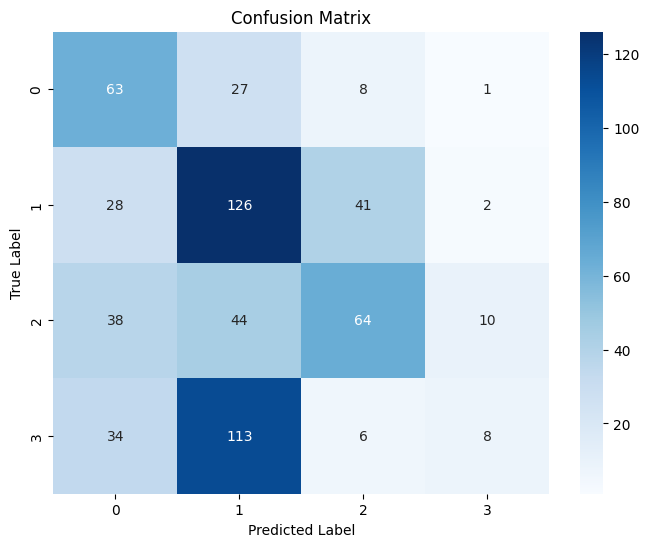

Training:   1%|          | 1/100 [00:01<01:52,  1.14s/it]

--------------------------------------------------
Best model saved at epoch 0 with F1 score: 0.3789
Epoch [2/100]
Train Loss: 1.3663, Train F1: 0.3690
Eval F1: 0.3918, Eval Precision: 0.4409, Eval Recall: 0.4323
Accuracy: 0.4323
Confusion Matrix:
 [[ 65  18  14   2]
 [ 30 111  54   2]
 [ 41  27  78  10]
 [ 35 105  10  11]]


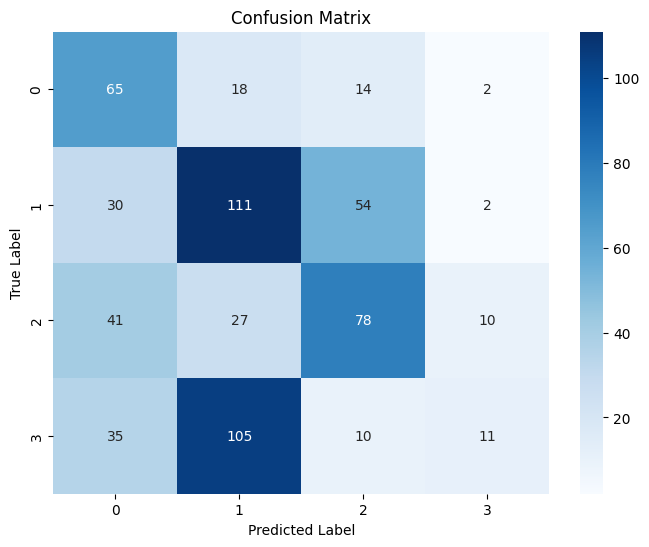

Training:   2%|▏         | 2/100 [00:02<01:50,  1.13s/it]

--------------------------------------------------
Best model saved at epoch 1 with F1 score: 0.3918
Epoch [3/100]
Train Loss: 1.3558, Train F1: 0.4112
Eval F1: 0.4814, Eval Precision: 0.5225, Eval Recall: 0.4845
Accuracy: 0.4845
Confusion Matrix:
 [[ 64  14  15   6]
 [ 29 102  55  11]
 [ 42  27  79   8]
 [ 34  64  11  52]]


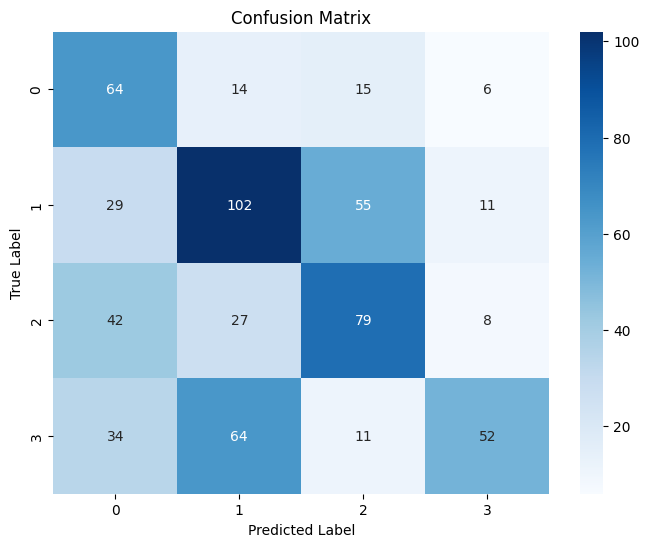

Training:   3%|▎         | 3/100 [00:03<02:01,  1.25s/it]

--------------------------------------------------
Best model saved at epoch 2 with F1 score: 0.4814
Epoch [4/100]
Train Loss: 1.3489, Train F1: 0.4281
Eval F1: 0.5028, Eval Precision: 0.5262, Eval Recall: 0.5008
Accuracy: 0.5008
Confusion Matrix:
 [[64 10 15 10]
 [29 93 54 21]
 [41 26 79 10]
 [34 45 11 71]]


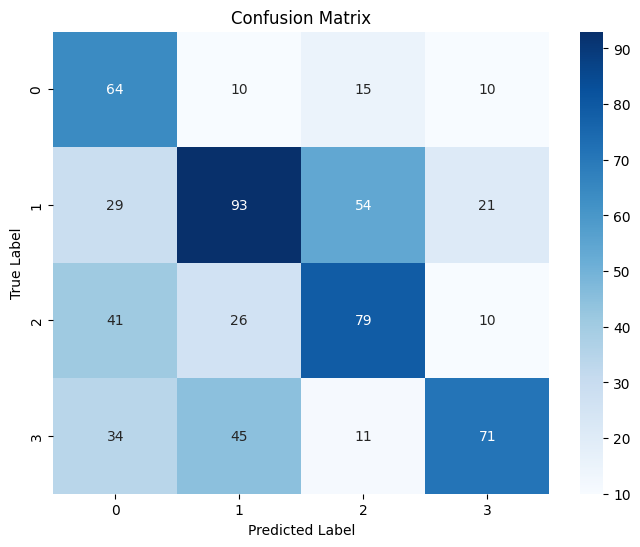

Training:   4%|▍         | 4/100 [00:04<02:01,  1.26s/it]

--------------------------------------------------
Best model saved at epoch 3 with F1 score: 0.5028
Epoch [5/100]
Train Loss: 1.3420, Train F1: 0.4500
Eval F1: 0.4973, Eval Precision: 0.5187, Eval Recall: 0.4959
Accuracy: 0.4959
Confusion Matrix:
 [[64  9 15 11]
 [29 87 55 26]
 [41 24 80 11]
 [35 42 11 73]]


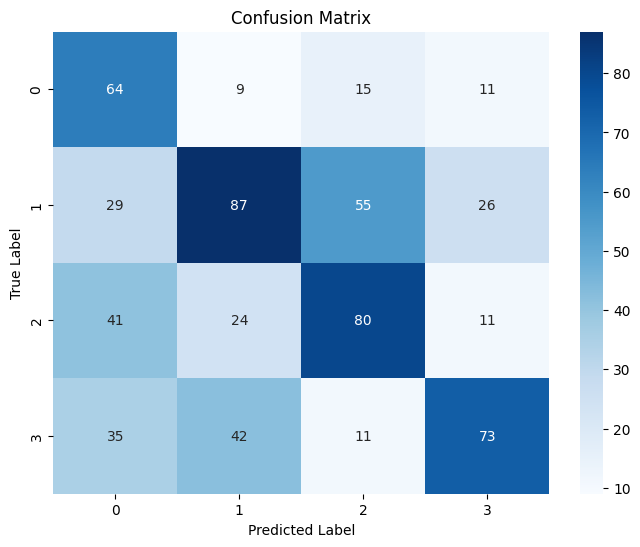

Training:   5%|▌         | 5/100 [00:06<01:54,  1.20s/it]

--------------------------------------------------
Epoch [6/100]
Train Loss: 1.3365, Train F1: 0.4652
Eval F1: 0.5027, Eval Precision: 0.5227, Eval Recall: 0.5008
Accuracy: 0.5008
Confusion Matrix:
 [[63  9 16 11]
 [28 89 54 26]
 [40 25 80 11]
 [34 41 11 75]]


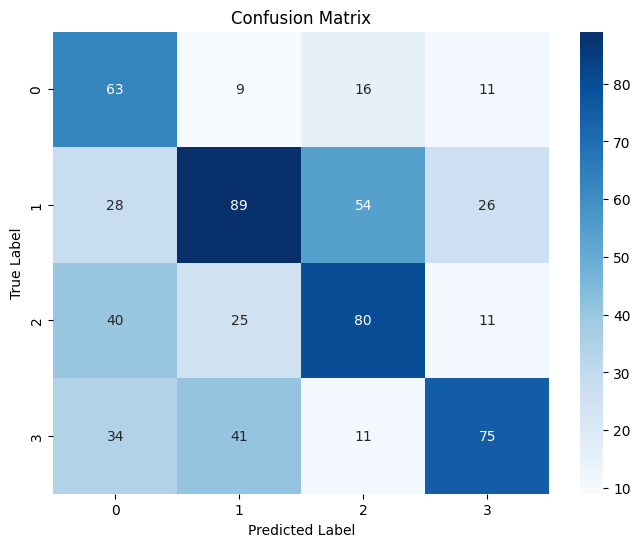

Training:   6%|▌         | 6/100 [00:07<01:49,  1.17s/it]

--------------------------------------------------
Epoch [7/100]
Train Loss: 1.3294, Train F1: 0.4862
Eval F1: 0.5045, Eval Precision: 0.5246, Eval Recall: 0.5024
Accuracy: 0.5024
Confusion Matrix:
 [[63  8 16 12]
 [28 88 54 27]
 [40 23 80 13]
 [35 38 11 77]]


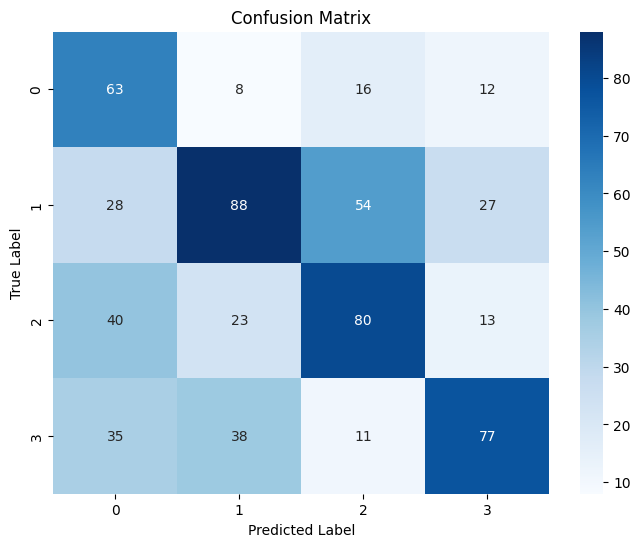

Training:   7%|▋         | 7/100 [00:08<01:47,  1.15s/it]

--------------------------------------------------
Best model saved at epoch 6 with F1 score: 0.5045
Epoch [8/100]
Train Loss: 1.3241, Train F1: 0.4967
Eval F1: 0.5097, Eval Precision: 0.5284, Eval Recall: 0.5073
Accuracy: 0.5073
Confusion Matrix:
 [[63  9 16 11]
 [28 92 50 27]
 [40 25 78 13]
 [33 38 12 78]]


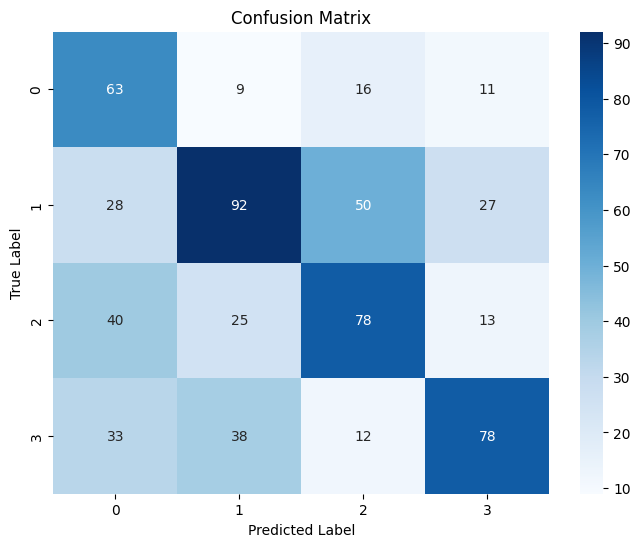

Training:   8%|▊         | 8/100 [00:09<01:45,  1.15s/it]

--------------------------------------------------
Best model saved at epoch 7 with F1 score: 0.5097
Epoch [9/100]
Train Loss: 1.3207, Train F1: 0.4837
Eval F1: 0.5078, Eval Precision: 0.5282, Eval Recall: 0.5057
Accuracy: 0.5057
Confusion Matrix:
 [[63  8 16 12]
 [28 88 54 27]
 [40 22 81 13]
 [34 37 12 78]]


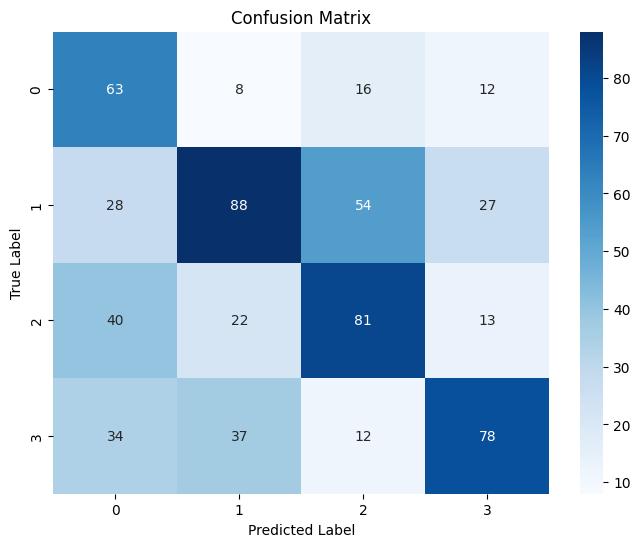

Training:   9%|▉         | 9/100 [00:10<01:43,  1.14s/it]

--------------------------------------------------
Epoch [10/100]
Train Loss: 1.3183, Train F1: 0.5038
Eval F1: 0.5098, Eval Precision: 0.5300, Eval Recall: 0.5073
Accuracy: 0.5073
Confusion Matrix:
 [[63  8 16 12]
 [27 90 53 27]
 [41 23 80 12]
 [34 37 12 78]]


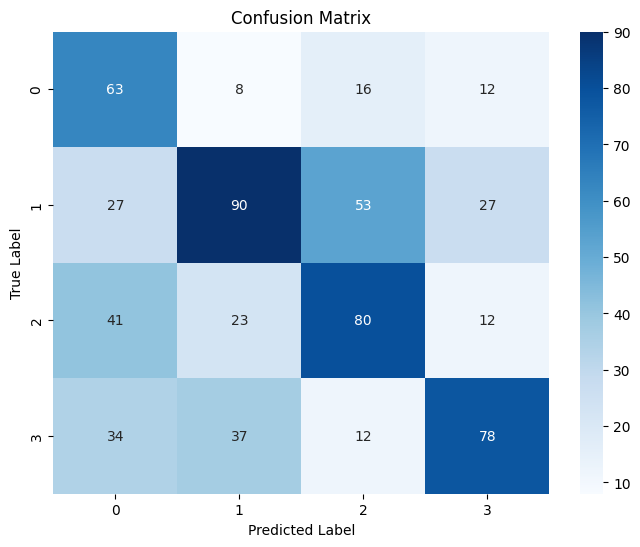

Training:  10%|█         | 10/100 [00:11<01:41,  1.13s/it]

--------------------------------------------------
Best model saved at epoch 9 with F1 score: 0.5098
Epoch [11/100]
Train Loss: 1.3148, Train F1: 0.5046
Eval F1: 0.5084, Eval Precision: 0.5289, Eval Recall: 0.5057
Accuracy: 0.5057
Confusion Matrix:
 [[62  7 17 13]
 [27 89 54 27]
 [41 23 80 12]
 [34 36 12 79]]


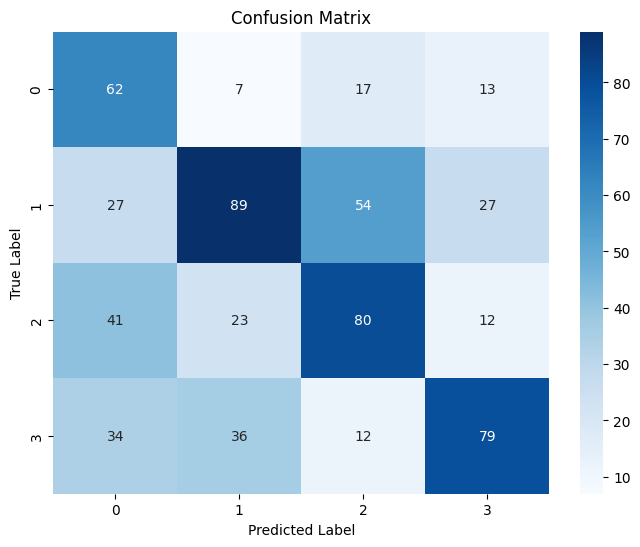

Training:  11%|█         | 11/100 [00:12<01:40,  1.12s/it]

--------------------------------------------------
Epoch [12/100]
Train Loss: 1.3163, Train F1: 0.4994
Eval F1: 0.5099, Eval Precision: 0.5307, Eval Recall: 0.5073
Accuracy: 0.5073
Confusion Matrix:
 [[63  7 16 13]
 [28 89 53 27]
 [41 23 80 12]
 [34 36 12 79]]


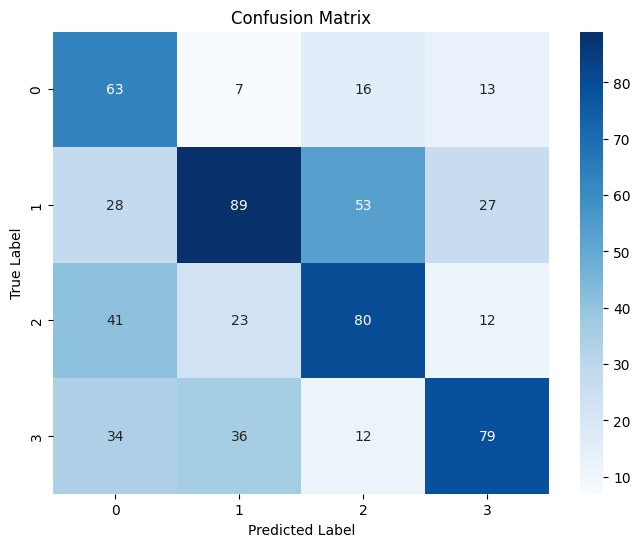

Training:  12%|█▏        | 12/100 [00:13<01:39,  1.13s/it]

--------------------------------------------------
Best model saved at epoch 11 with F1 score: 0.5099
Epoch [13/100]
Train Loss: 1.3113, Train F1: 0.5057
Eval F1: 0.5084, Eval Precision: 0.5273, Eval Recall: 0.5057
Accuracy: 0.5057
Confusion Matrix:
 [[60  7 19 13]
 [26 89 55 27]
 [38 23 82 13]
 [34 36 12 79]]


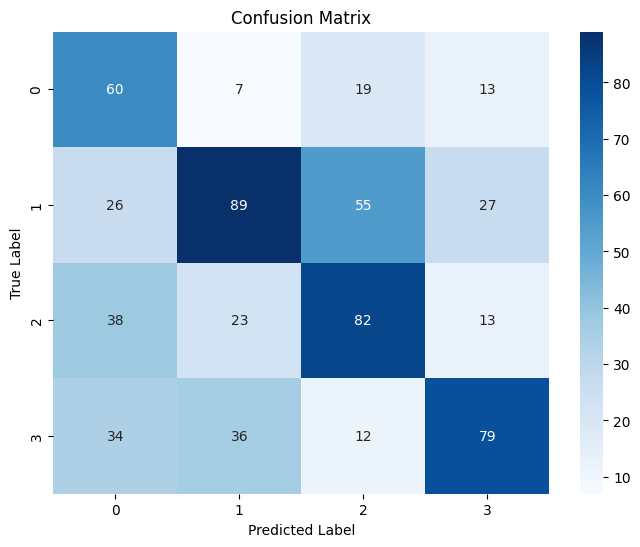

Training:  13%|█▎        | 13/100 [00:14<01:36,  1.11s/it]

--------------------------------------------------
Epoch [14/100]
Train Loss: 1.3124, Train F1: 0.4974
Eval F1: 0.5085, Eval Precision: 0.5285, Eval Recall: 0.5057
Accuracy: 0.5057
Confusion Matrix:
 [[62  7 17 13]
 [27 90 53 27]
 [41 24 79 12]
 [34 36 12 79]]


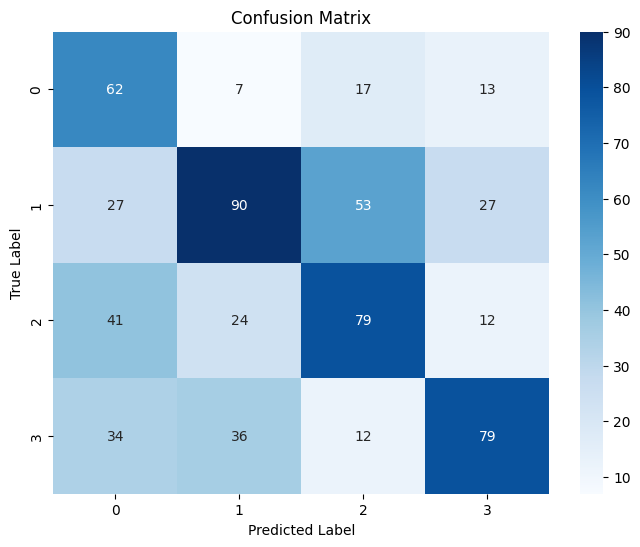

Training:  14%|█▍        | 14/100 [00:16<01:34,  1.10s/it]

--------------------------------------------------
Epoch [15/100]
Train Loss: 1.3097, Train F1: 0.5002
Eval F1: 0.5136, Eval Precision: 0.5349, Eval Recall: 0.5106
Accuracy: 0.5106
Confusion Matrix:
 [[62  6 17 14]
 [27 88 54 28]
 [41 23 80 12]
 [34 32 12 83]]


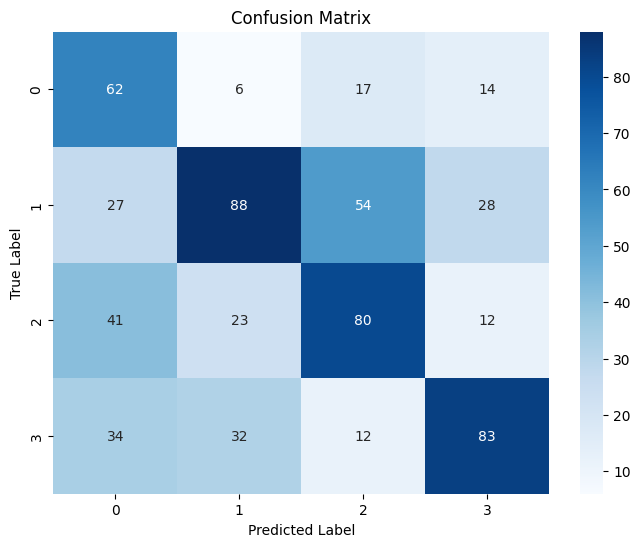

Training:  15%|█▌        | 15/100 [00:17<01:34,  1.12s/it]

--------------------------------------------------
Best model saved at epoch 14 with F1 score: 0.5136
Epoch [16/100]
Train Loss: 1.3077, Train F1: 0.5072
Eval F1: 0.5151, Eval Precision: 0.5329, Eval Recall: 0.5122
Accuracy: 0.5122
Confusion Matrix:
 [[61  7 18 13]
 [26 94 50 27]
 [38 25 80 13]
 [34 36 12 79]]


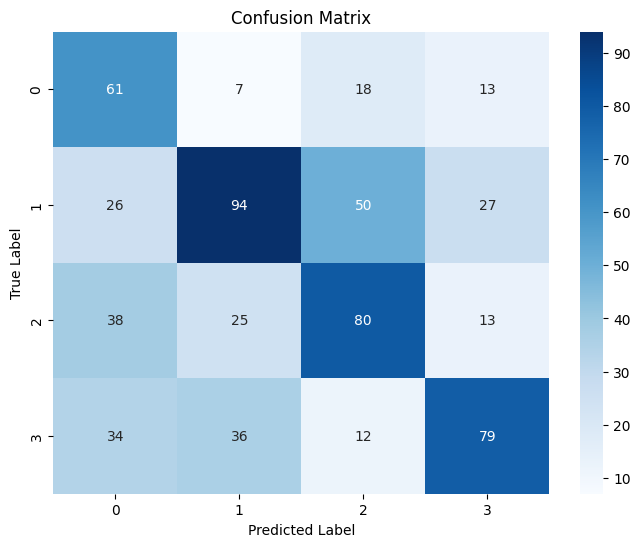

Training:  16%|█▌        | 16/100 [00:18<01:33,  1.11s/it]

--------------------------------------------------
Best model saved at epoch 15 with F1 score: 0.5151
Epoch [17/100]
Train Loss: 1.3076, Train F1: 0.5091
Eval F1: 0.5103, Eval Precision: 0.5286, Eval Recall: 0.5073
Accuracy: 0.5073
Confusion Matrix:
 [[60  7 19 13]
 [26 91 53 27]
 [38 25 81 12]
 [34 36 12 79]]


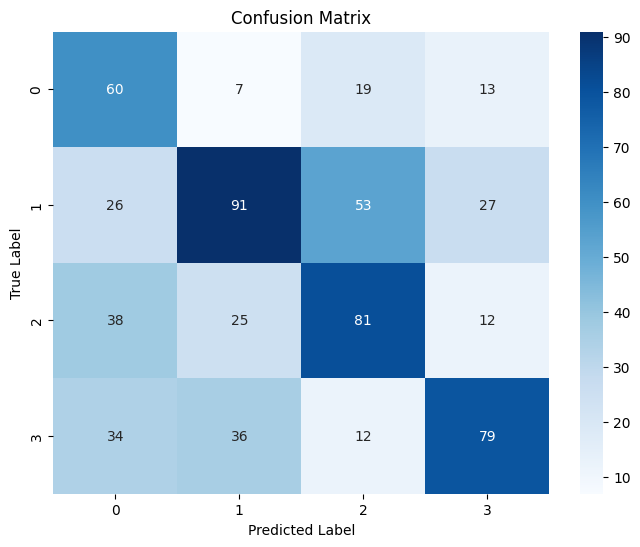

Training:  17%|█▋        | 17/100 [00:19<01:31,  1.10s/it]

--------------------------------------------------
Epoch [18/100]
Train Loss: 1.3064, Train F1: 0.5059
Eval F1: 0.5136, Eval Precision: 0.5320, Eval Recall: 0.5106
Accuracy: 0.5106
Confusion Matrix:
 [[61  7 18 13]
 [26 93 51 27]
 [39 25 80 12]
 [34 36 12 79]]


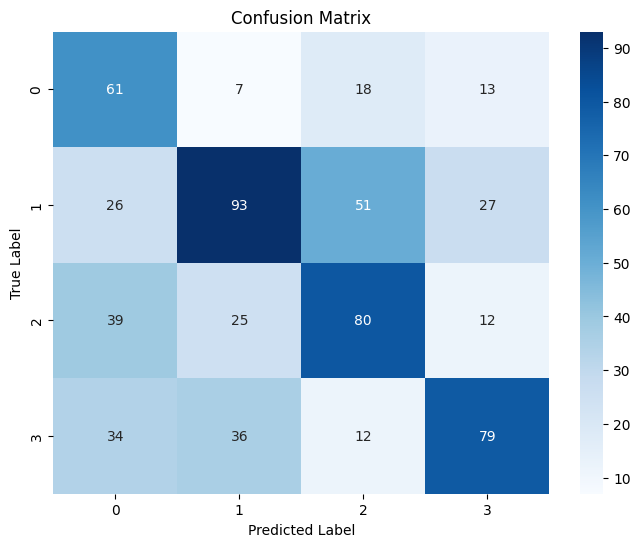

Training:  18%|█▊        | 18/100 [00:20<01:29,  1.09s/it]

--------------------------------------------------
Epoch [19/100]
Train Loss: 1.3058, Train F1: 0.5074
Eval F1: 0.5088, Eval Precision: 0.5274, Eval Recall: 0.5057
Accuracy: 0.5057
Confusion Matrix:
 [[60  7 19 13]
 [26 91 53 27]
 [39 25 80 12]
 [34 36 12 79]]


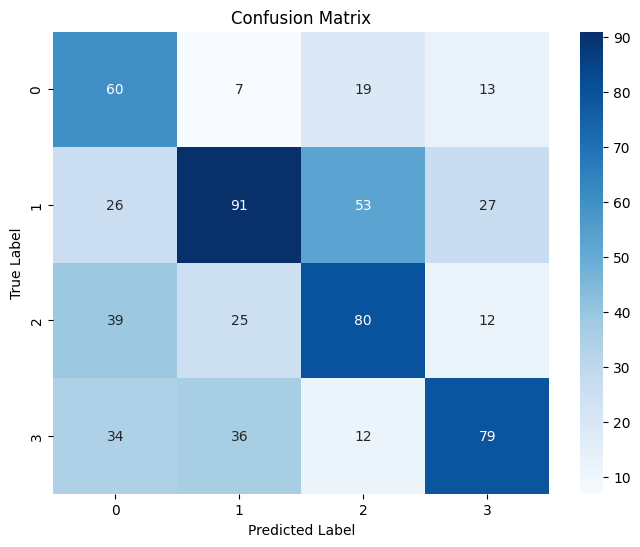

Training:  19%|█▉        | 19/100 [00:21<01:28,  1.10s/it]

--------------------------------------------------
Epoch [20/100]
Train Loss: 1.3063, Train F1: 0.4996
Eval F1: 0.5107, Eval Precision: 0.5318, Eval Recall: 0.5073
Accuracy: 0.5073
Confusion Matrix:
 [[61  6 18 14]
 [27 88 53 29]
 [42 24 79 11]
 [34 32 12 83]]


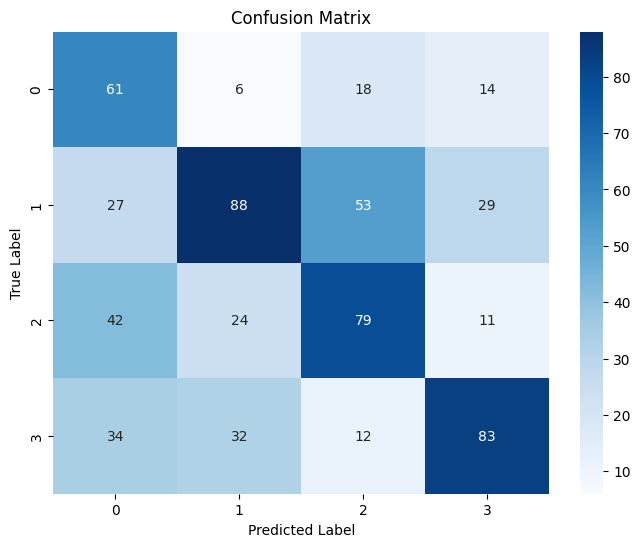

Training:  20%|██        | 20/100 [00:22<01:27,  1.10s/it]

--------------------------------------------------
Epoch [21/100]
Train Loss: 1.3053, Train F1: 0.5070
Eval F1: 0.5114, Eval Precision: 0.5314, Eval Recall: 0.5090
Accuracy: 0.5090
Confusion Matrix:
 [[61  6 18 14]
 [26 87 55 29]
 [39 23 82 12]
 [34 33 12 82]]


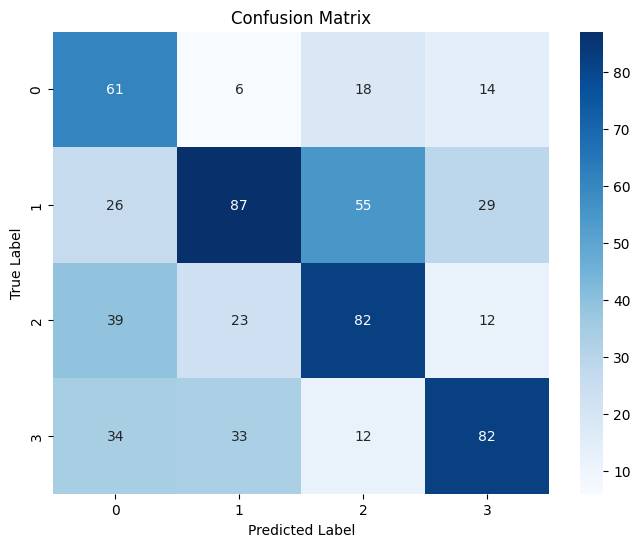

Training:  21%|██        | 21/100 [00:23<01:31,  1.16s/it]

--------------------------------------------------
Epoch [22/100]
Train Loss: 1.3051, Train F1: 0.5052
Eval F1: 0.5140, Eval Precision: 0.5323, Eval Recall: 0.5106
Accuracy: 0.5106
Confusion Matrix:
 [[60  7 19 13]
 [26 94 50 27]
 [39 25 80 12]
 [34 36 12 79]]


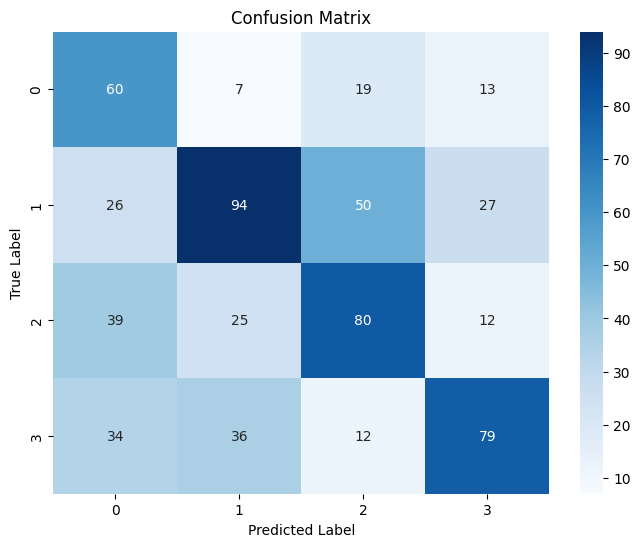

Training:  22%|██▏       | 22/100 [00:25<01:29,  1.14s/it]

--------------------------------------------------
Epoch [23/100]
Train Loss: 1.3040, Train F1: 0.5075
Eval F1: 0.5124, Eval Precision: 0.5329, Eval Recall: 0.5090
Accuracy: 0.5090
Confusion Matrix:
 [[60  6 19 14]
 [26 89 55 27]
 [40 24 81 11]
 [34 33 12 82]]


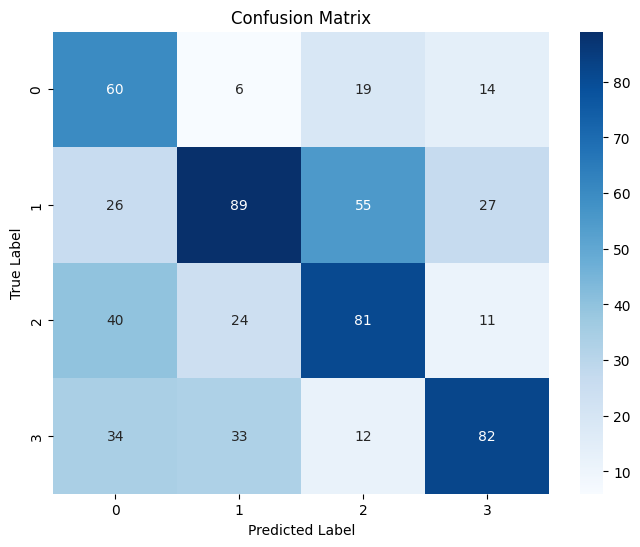

Training:  23%|██▎       | 23/100 [00:26<01:26,  1.13s/it]

--------------------------------------------------
Epoch [24/100]
Train Loss: 1.3053, Train F1: 0.5045
Eval F1: 0.5185, Eval Precision: 0.5368, Eval Recall: 0.5155
Accuracy: 0.5155
Confusion Matrix:
 [[61  6 18 14]
 [26 92 50 29]
 [38 25 80 13]
 [34 32 12 83]]


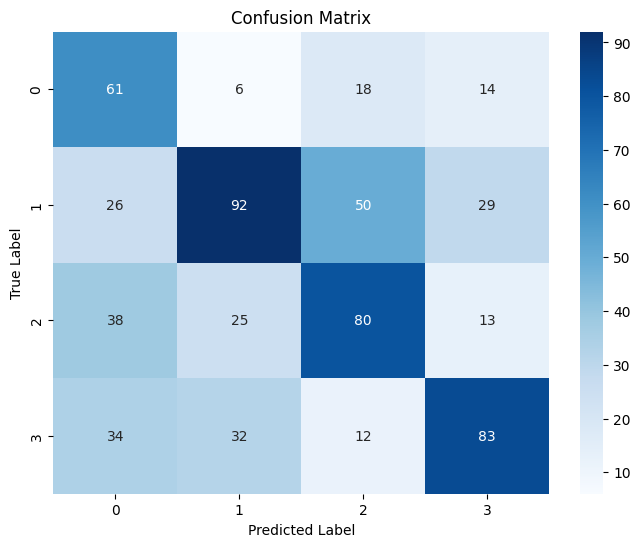

Training:  24%|██▍       | 24/100 [00:27<01:25,  1.13s/it]

--------------------------------------------------
Best model saved at epoch 23 with F1 score: 0.5185
Epoch [25/100]
Train Loss: 1.3040, Train F1: 0.5022
Eval F1: 0.5120, Eval Precision: 0.5316, Eval Recall: 0.5090
Accuracy: 0.5090
Confusion Matrix:
 [[60  6 19 14]
 [26 88 54 29]
 [39 24 81 12]
 [34 32 12 83]]


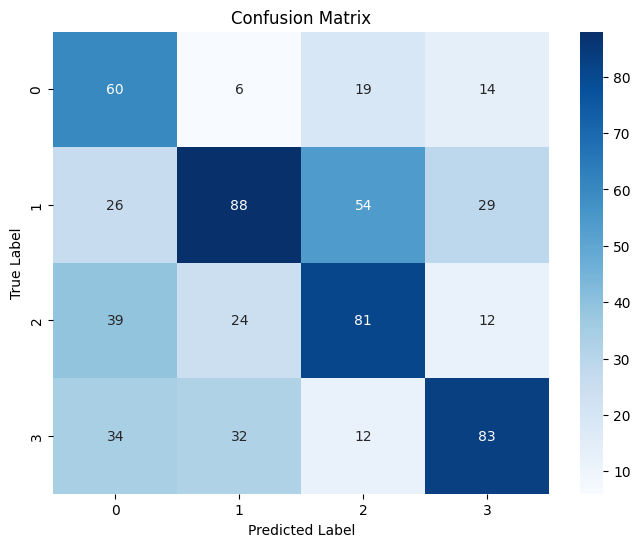

Training:  25%|██▌       | 25/100 [00:28<01:23,  1.11s/it]

--------------------------------------------------
Epoch [26/100]
Train Loss: 1.3027, Train F1: 0.5064
Eval F1: 0.5103, Eval Precision: 0.5308, Eval Recall: 0.5073
Accuracy: 0.5073
Confusion Matrix:
 [[60  6 19 14]
 [26 87 55 29]
 [40 23 82 11]
 [34 33 12 82]]


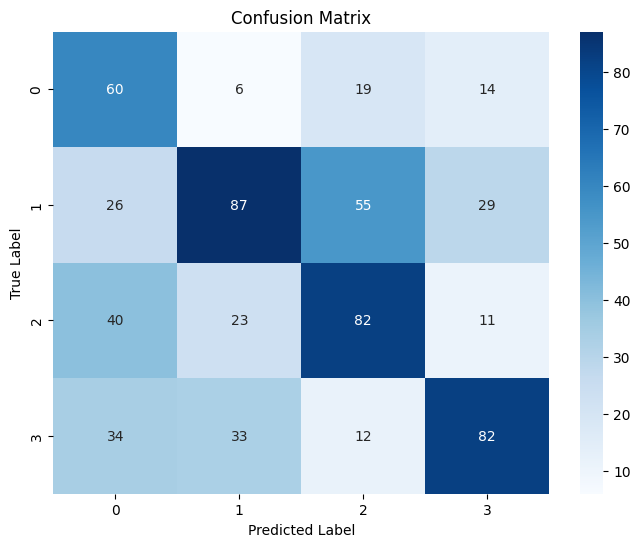

Training:  26%|██▌       | 26/100 [00:29<01:21,  1.11s/it]

--------------------------------------------------
Epoch [27/100]
Train Loss: 1.3035, Train F1: 0.5031
Eval F1: 0.5153, Eval Precision: 0.5330, Eval Recall: 0.5122
Accuracy: 0.5122
Confusion Matrix:
 [[60  6 19 14]
 [26 94 50 27]
 [38 25 81 12]
 [33 36 13 79]]


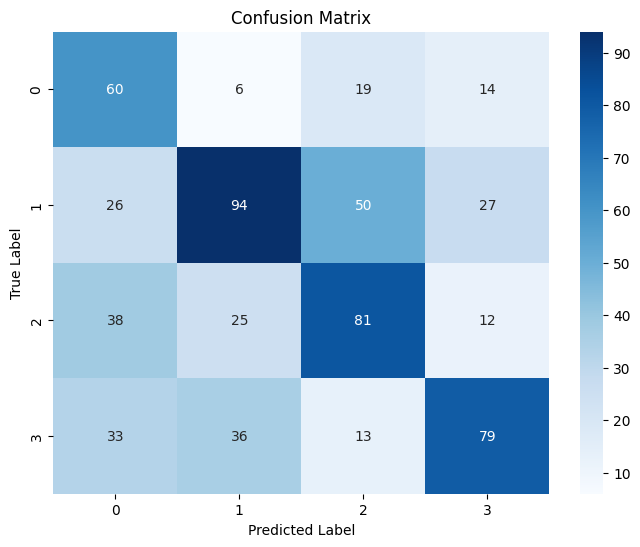

Training:  27%|██▋       | 27/100 [00:30<01:20,  1.11s/it]

--------------------------------------------------
Epoch [28/100]
Train Loss: 1.3025, Train F1: 0.5025
Eval F1: 0.5153, Eval Precision: 0.5330, Eval Recall: 0.5122
Accuracy: 0.5122
Confusion Matrix:
 [[60  6 19 14]
 [26 94 50 27]
 [38 25 81 12]
 [33 36 13 79]]


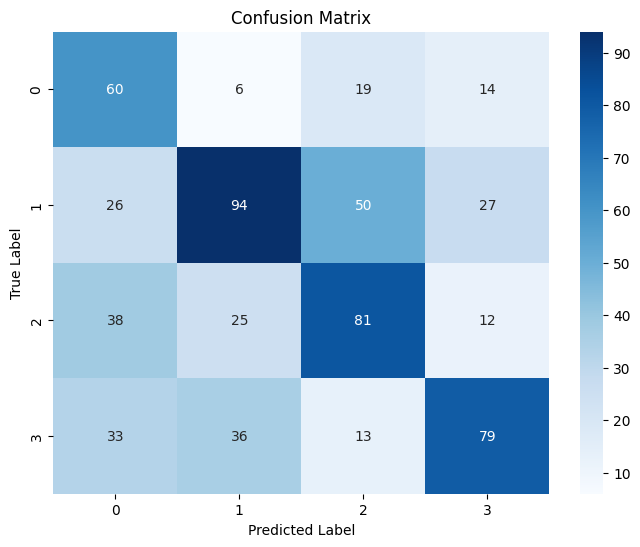

Training:  28%|██▊       | 28/100 [00:31<01:19,  1.11s/it]

--------------------------------------------------
Epoch [29/100]
Train Loss: 1.3022, Train F1: 0.5050
Eval F1: 0.5154, Eval Precision: 0.5350, Eval Recall: 0.5122
Accuracy: 0.5122
Confusion Matrix:
 [[61  6 18 14]
 [26 90 52 29]
 [40 25 80 11]
 [34 32 12 83]]


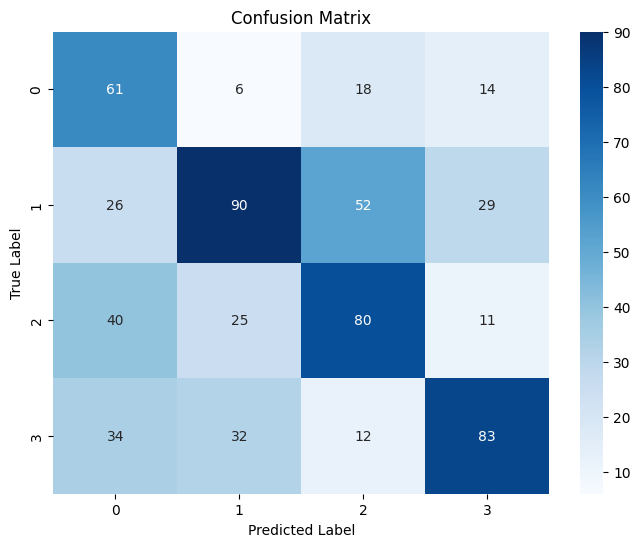

Training:  29%|██▉       | 29/100 [00:32<01:18,  1.10s/it]

--------------------------------------------------
Epoch [30/100]
Train Loss: 1.3022, Train F1: 0.5062
Eval F1: 0.5119, Eval Precision: 0.5301, Eval Recall: 0.5090
Accuracy: 0.5090
Confusion Matrix:
 [[60  6 19 14]
 [26 91 53 27]
 [38 25 81 12]
 [33 35 13 80]]


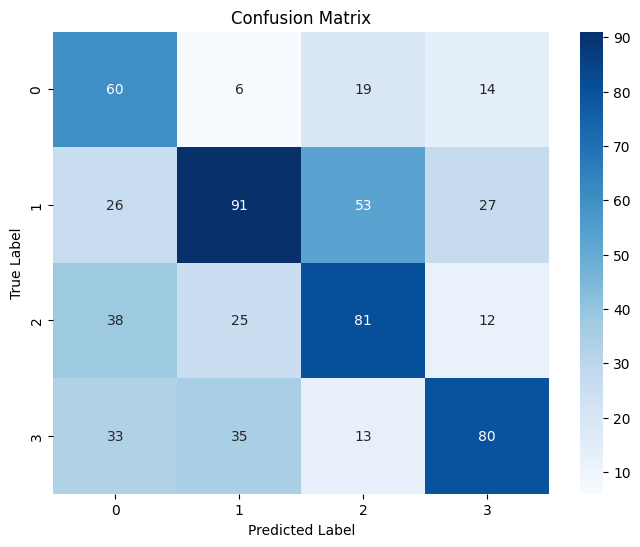

Training:  30%|███       | 30/100 [00:33<01:17,  1.11s/it]

--------------------------------------------------
Epoch [31/100]
Train Loss: 1.3039, Train F1: 0.5071
Eval F1: 0.5121, Eval Precision: 0.5322, Eval Recall: 0.5090
Accuracy: 0.5090
Confusion Matrix:
 [[61  6 18 14]
 [26 89 53 29]
 [41 25 79 11]
 [34 32 12 83]]


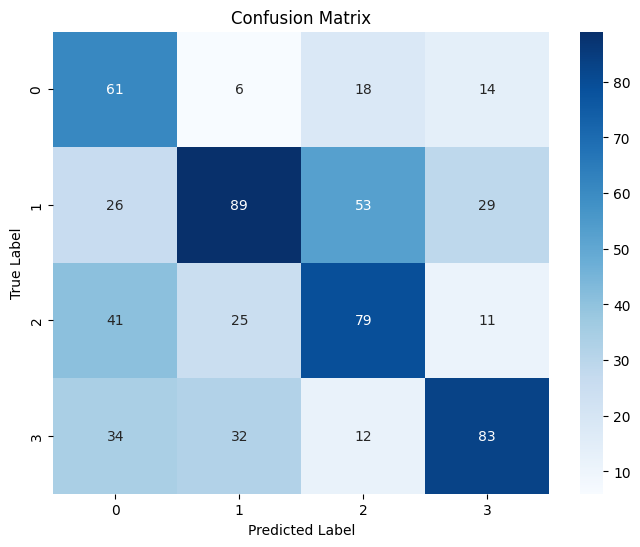

Training:  31%|███       | 31/100 [00:35<01:17,  1.12s/it]

--------------------------------------------------
Epoch [32/100]
Train Loss: 1.3030, Train F1: 0.5076
Eval F1: 0.5139, Eval Precision: 0.5313, Eval Recall: 0.5106
Accuracy: 0.5106
Confusion Matrix:
 [[59  7 20 13]
 [25 94 51 27]
 [38 25 81 12]
 [33 36 13 79]]


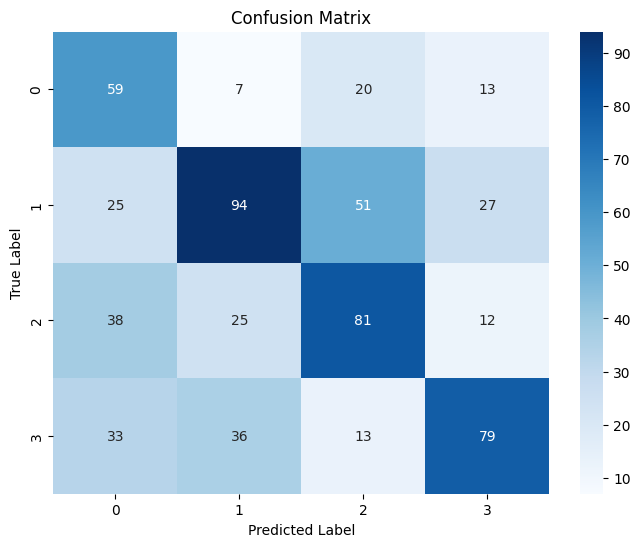

Training:  32%|███▏      | 32/100 [00:36<01:19,  1.17s/it]

--------------------------------------------------
Epoch [33/100]
Train Loss: 1.3041, Train F1: 0.5030
Eval F1: 0.5222, Eval Precision: 0.5415, Eval Recall: 0.5188
Accuracy: 0.5188
Confusion Matrix:
 [[61  6 18 14]
 [26 92 50 29]
 [39 25 80 12]
 [34 30 12 85]]


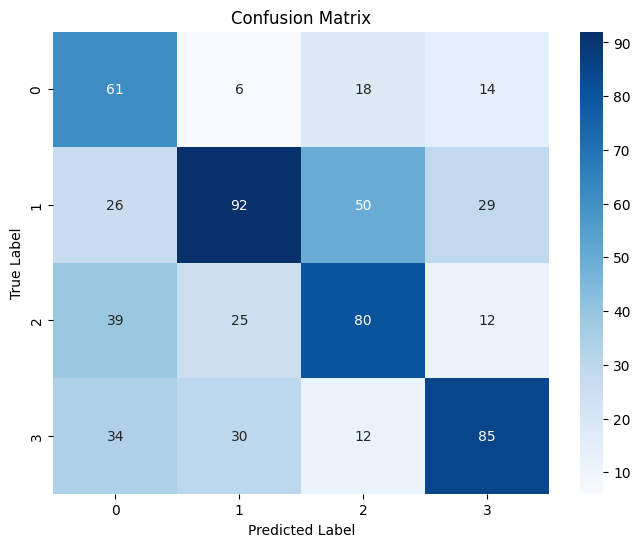

Training:  33%|███▎      | 33/100 [00:37<01:17,  1.16s/it]

--------------------------------------------------
Best model saved at epoch 32 with F1 score: 0.5222
Epoch [34/100]
Train Loss: 1.3024, Train F1: 0.4997
Eval F1: 0.5073, Eval Precision: 0.5264, Eval Recall: 0.5041
Accuracy: 0.5041
Confusion Matrix:
 [[59  6 20 14]
 [26 91 53 27]
 [39 25 81 11]
 [34 36 13 78]]


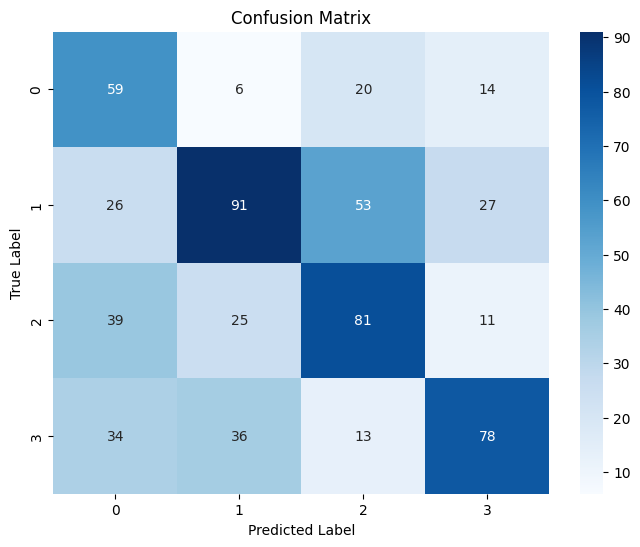

Training:  34%|███▍      | 34/100 [00:38<01:14,  1.13s/it]

--------------------------------------------------
Epoch [35/100]
Train Loss: 1.3008, Train F1: 0.5085
Eval F1: 0.5155, Eval Precision: 0.5338, Eval Recall: 0.5122
Accuracy: 0.5122
Confusion Matrix:
 [[60  6 19 14]
 [26 94 50 27]
 [39 25 81 11]
 [33 36 13 79]]


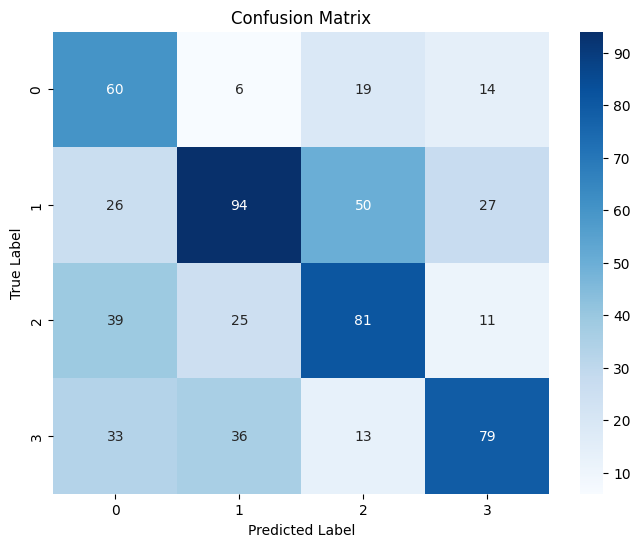

Training:  35%|███▌      | 35/100 [00:39<01:12,  1.12s/it]

--------------------------------------------------
Epoch [36/100]
Train Loss: 1.3005, Train F1: 0.5071
Eval F1: 0.5205, Eval Precision: 0.5395, Eval Recall: 0.5171
Accuracy: 0.5171
Confusion Matrix:
 [[61  6 18 14]
 [26 92 50 29]
 [39 25 80 12]
 [34 31 12 84]]


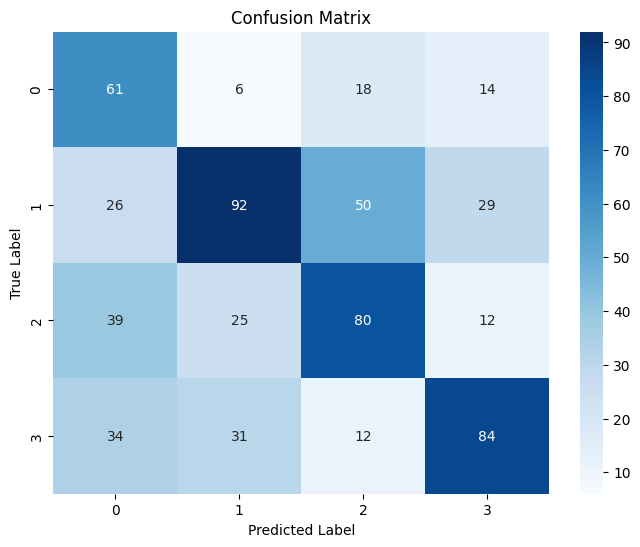

Training:  36%|███▌      | 36/100 [00:40<01:15,  1.19s/it]

--------------------------------------------------
Epoch [37/100]
Train Loss: 1.3019, Train F1: 0.5061
Eval F1: 0.5170, Eval Precision: 0.5349, Eval Recall: 0.5139
Accuracy: 0.5139
Confusion Matrix:
 [[60  6 19 14]
 [26 92 50 29]
 [38 25 81 12]
 [33 33 13 82]]


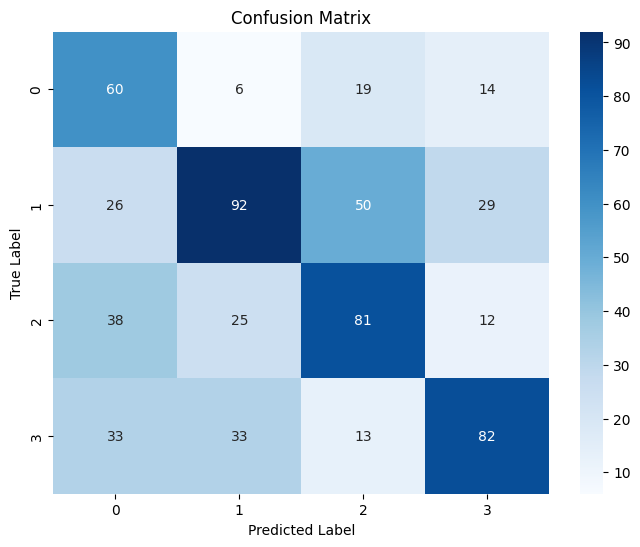

Training:  37%|███▋      | 37/100 [00:42<01:13,  1.16s/it]

--------------------------------------------------
Epoch [38/100]
Train Loss: 1.3012, Train F1: 0.5049
Eval F1: 0.5090, Eval Precision: 0.5289, Eval Recall: 0.5057
Accuracy: 0.5057
Confusion Matrix:
 [[60  6 19 14]
 [26 89 53 29]
 [40 25 80 11]
 [35 33 12 81]]


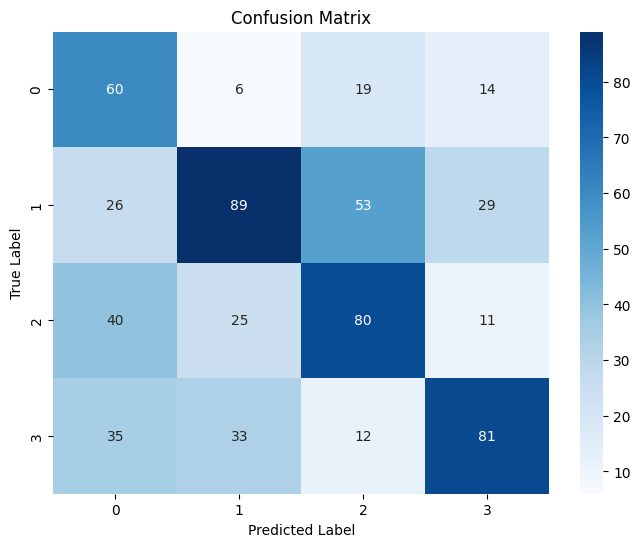

Training:  38%|███▊      | 38/100 [00:43<01:10,  1.14s/it]

--------------------------------------------------
Epoch [39/100]
Train Loss: 1.2996, Train F1: 0.5037
Eval F1: 0.5120, Eval Precision: 0.5312, Eval Recall: 0.5090
Accuracy: 0.5090
Confusion Matrix:
 [[60  6 19 14]
 [26 89 53 29]
 [39 25 81 11]
 [34 33 12 82]]


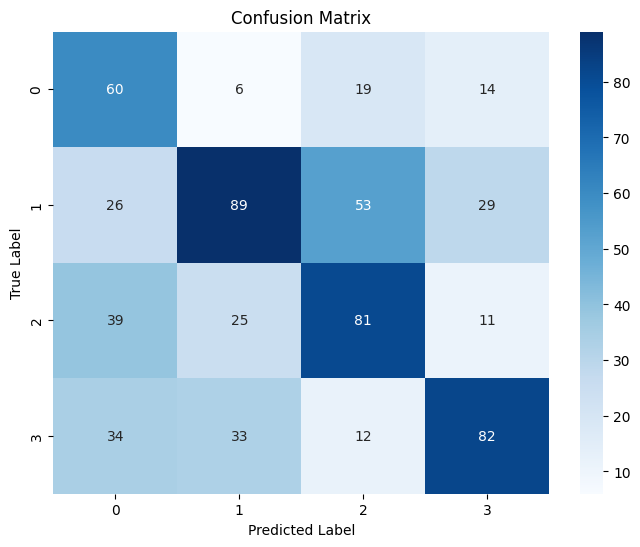

Training:  39%|███▉      | 39/100 [00:44<01:08,  1.13s/it]

--------------------------------------------------
Epoch [40/100]
Train Loss: 1.3002, Train F1: 0.5053
Eval F1: 0.5090, Eval Precision: 0.5289, Eval Recall: 0.5057
Accuracy: 0.5057
Confusion Matrix:
 [[60  6 19 14]
 [26 89 53 29]
 [40 25 80 11]
 [35 33 12 81]]


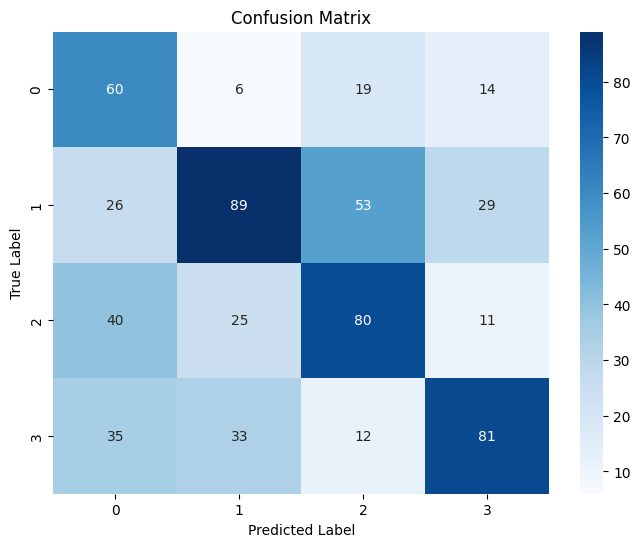

Training:  40%|████      | 40/100 [00:45<01:07,  1.12s/it]

--------------------------------------------------
Epoch [41/100]
Train Loss: 1.3020, Train F1: 0.4980
Eval F1: 0.5120, Eval Precision: 0.5312, Eval Recall: 0.5090
Accuracy: 0.5090
Confusion Matrix:
 [[60  6 19 14]
 [26 89 53 29]
 [39 25 81 11]
 [34 33 12 82]]


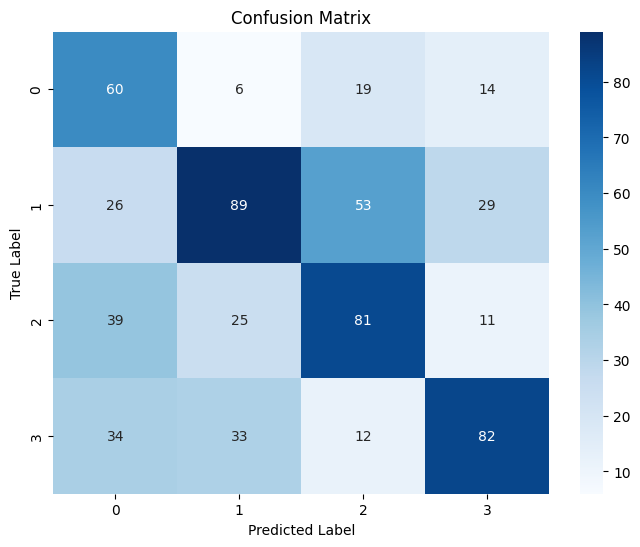

Training:  41%|████      | 41/100 [00:46<01:06,  1.13s/it]

--------------------------------------------------
Epoch [42/100]
Train Loss: 1.3016, Train F1: 0.5011
Eval F1: 0.5137, Eval Precision: 0.5311, Eval Recall: 0.5106
Accuracy: 0.5106
Confusion Matrix:
 [[60  7 19 13]
 [26 94 50 27]
 [38 26 80 12]
 [33 36 13 79]]


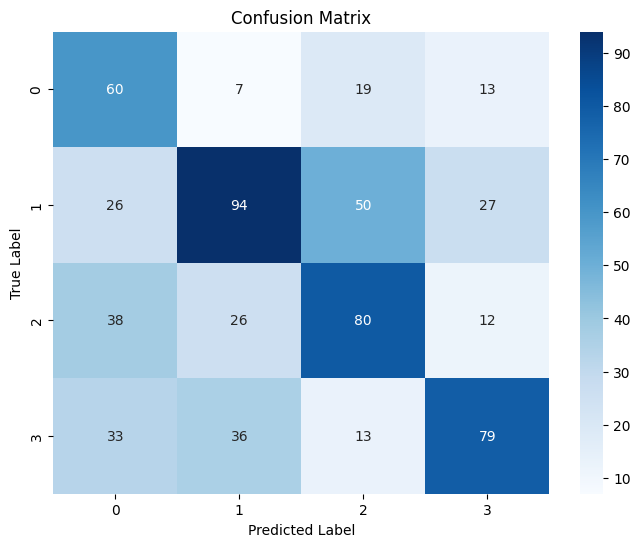

Training:  42%|████▏     | 42/100 [00:47<01:05,  1.12s/it]

--------------------------------------------------
Epoch [43/100]
Train Loss: 1.3027, Train F1: 0.5060
Eval F1: 0.5158, Eval Precision: 0.5349, Eval Recall: 0.5122
Accuracy: 0.5122
Confusion Matrix:
 [[60  6 19 14]
 [26 92 50 29]
 [40 25 80 11]
 [34 33 12 82]]


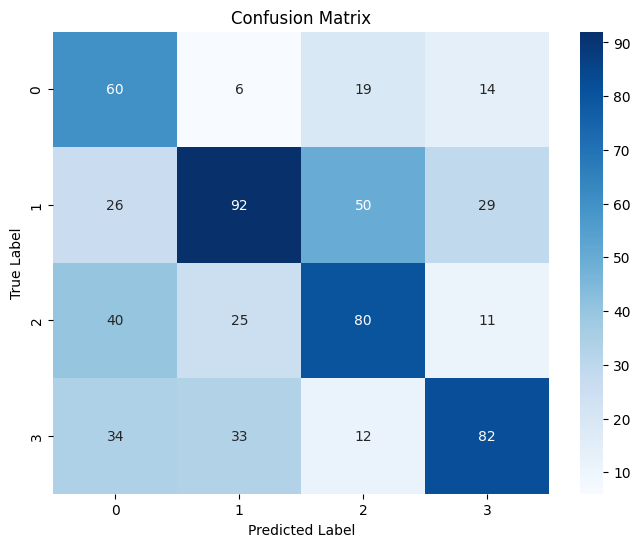

Training:  42%|████▏     | 42/100 [00:48<01:07,  1.16s/it]

--------------------------------------------------
Early stopping triggered after 43 epochs


In [104]:
set_seed(8)
model = train_and_evaluate(
    val_pred_probs = val_pred_probs,
    val_labels=labels_2)

## Kết quả trên tập test

In [105]:
method_2 = NeuralNet(input_size, hidden_size, num_classes)
weights = torch.load('/kaggle/working/best_model_epoch_32.pt')
print(weights['metrics']['f1_score'])
# Load trained model weights
method_2.load_state_dict(weights['model_state_dict'])
model = method_2.to(device)

0.5222128764261179


## Public:

In [106]:
probabilities, results_1 = predict_test(model, test_pub_1, test_pub_2)
print('Xác suất dự đoán: ', probabilities)
print('Nhãn dự đoán: ', results_1)

Xác suất dự đoán:  tensor([[0.9289, 0.0245, 0.0254, 0.0212],
        [0.8616, 0.0460, 0.0556, 0.0368],
        [0.6088, 0.1239, 0.1654, 0.1019],
        ...,
        [0.9137, 0.0294, 0.0285, 0.0284],
        [0.8968, 0.0350, 0.0374, 0.0308],
        [0.9057, 0.0314, 0.0282, 0.0347]], device='cuda:0')
Nhãn dự đoán:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


In [107]:
# Chuyển predicted_labels về CPU trước khi tạo DataFrame
pred = pd.DataFrame(results_1.cpu().numpy())

test_pub['label'] = pred

In [108]:
test_pub.to_csv('pub_pred_l20.csv', index = False)

## Private:

In [109]:
probabilities, results_2 = predict_test(model, test_priv_1, test_priv_2)
print('Xác suất dự đoán: ', probabilities)
print('Nhãn dự đoán: ', results_2)

Xác suất dự đoán:  tensor([[3.2363e-04, 9.8885e-01, 7.6083e-03, 3.2170e-03],
        [3.4551e-04, 9.8860e-01, 7.6228e-03, 3.4271e-03],
        [3.6988e-04, 9.8833e-01, 7.6384e-03, 3.6626e-03],
        ...,
        [9.7150e-01, 1.0117e-02, 8.8839e-03, 9.4942e-03],
        [9.7047e-01, 1.0322e-02, 8.5374e-03, 1.0666e-02],
        [7.6088e-01, 7.0527e-02, 1.2295e-01, 4.5650e-02]], device='cuda:0')
Nhãn dự đoán:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')


In [110]:
# Chuyển predicted_labels về CPU trước khi tạo DataFrame
pred = pd.DataFrame(results_2.cpu().numpy())

test_priv['label'] = pred
test_priv

,index,image,caption,label
0,0,066d6021fdfeaf39f1dec523879e8fe4d35e877abcea44...,Song Joong Ki &amp; Song Hye Kyo đều tham dự B...,1
1,1,555f4787d4df49e7be743b3d5b77c90755f0d6c351f36b...,Song Joong Ki &amp; Song Hye Kyo đều tham dự B...,1
2,2,7b7cdea2cde1f3f93371259b587a03f2e8c0af682b4d51...,Song Joong Ki &amp; Song Hye Kyo đều tham dự B...,1
3,3,80167e59d729cf3aaba5d2d3da40db6995cb8a6a8c4a88...,Song Joong Ki &amp; Song Hye Kyo đều tham dự B...,1
4,4,59db087307031d60755af3a5c01a44ba55a04bfab21027...,Ngang trái thậc 🤣,2
...,...,...,...,...
1499,1499,3c643826258f8aacc8a98d8e24956f909797010f1e80bd...,Mẹ biết mẹ buồn ó 🐧,0
1500,1500,09f5adf3e555d3066eae0be356e5ce797c066706e7c808...,Ủa ăn đi anh sao tự nhiên rén vậy? \n#KFCViet...,3
1501,1501,b11515c1aa521da4f6d0cd6464e5ea3e030662cdd43f7f...,Mẹ không phát hiện sớm là vài tháng nữa con Ch...,0
1502,1502,8a83634808704a5c7493327893f793effd6e78cb037ac4...,Anh em h.út ch.ích gánh còng lưng :(((,0


In [111]:
test_priv.to_csv('priv_pred_l20.csv', index = False)